# Intro notebook
The purpose of this notebook is to connect to a local database that we created by loading CSV files into that database.
Copy / paste this notebook into other places to add / delete cells and add new analysis.

In [10]:
import os
from pathlib import Path
from sqlalchemy import create_engine
import sqlite3

In [ ]:
# Step 1: Load the SQL extension
%load_ext sql

In [477]:
nfl_db_raw = Path.cwd().parent.parent / 'raw_data' / 'nfl' / 'src_code' / 'nfl.db'
nfl_db_path = nfl_db_raw.resolve()
adp_db_raw = Path.cwd().parent.parent / 'raw_data' / 'adp' / 'src_code' / 'adp.db'
adp_db_path = adp_db_raw.resolve()

In [582]:
# Step 2: Connect to the first SQLite database
%sql sqlite:///{nfl_db_path}

# Step 3: Attach the ADP database
%sql DETACH DATABASE adp_db;
%sql ATTACH '{adp_db_path}' AS adp_db;

   sqlite:////Users/beoconno/Documents/ff/ff_data/raw_data/adp/src_code/adp.db
 * sqlite:////Users/beoconno/Documents/ff/ff_data/raw_data/nfl/src_code/nfl.db
Done.
   sqlite:////Users/beoconno/Documents/ff/ff_data/raw_data/adp/src_code/adp.db
 * sqlite:////Users/beoconno/Documents/ff/ff_data/raw_data/nfl/src_code/nfl.db
Done.


[]

# Join adp and nfl data

### Players that we have adp data on

In [417]:
%%sql
SELECT COUNT(DISTINCT player) AS player_cnt
FROM historical_adp 
LIMIT 10
;

   sqlite:////Users/beoconno/Documents/ff/ff_data/raw_data/adp/src_code/adp.db
 * sqlite:////Users/beoconno/Documents/ff/ff_data/raw_data/nfl/src_code/nfl.db
Done.


[(1384,)]

In [420]:
%%sql
SELECT year, COUNT(DISTINCT player) AS player_cnt
FROM historical_adp 
GROUP BY 1
ORDER BY 1
LIMIT 10
;

   sqlite:////Users/beoconno/Documents/ff/ff_data/raw_data/adp/src_code/adp.db
 * sqlite:////Users/beoconno/Documents/ff/ff_data/raw_data/nfl/src_code/nfl.db
Done.


[('2015', 461),
 ('2016', 551),
 ('2017', 409),
 ('2018', 481),
 ('2019', 455),
 ('2020', 391),
 ('2021', 211),
 ('2022', 294),
 ('2023', 360),
 ('2024', 338)]

### Players that we have nfl data for

In [418]:
%%sql
SELECT COUNT(DISTINCT cleaned_player) AS player_cnt
FROM nfl_enhanced 
LIMIT 10
;

   sqlite:////Users/beoconno/Documents/ff/ff_data/raw_data/adp/src_code/adp.db
 * sqlite:////Users/beoconno/Documents/ff/ff_data/raw_data/nfl/src_code/nfl.db
Done.


[(1598,)]

In [421]:
%%sql
SELECT YEAR, COUNT(DISTINCT cleaned_player) AS player_cnt
FROM nfl_enhanced 
GROUP BY 1
ORDER BY 1
LIMIT 10
;

   sqlite:////Users/beoconno/Documents/ff/ff_data/raw_data/adp/src_code/adp.db
 * sqlite:////Users/beoconno/Documents/ff/ff_data/raw_data/nfl/src_code/nfl.db
Done.


[('2016', 590),
 ('2017', 599),
 ('2018', 620),
 ('2019', 614),
 ('2020', 657),
 ('2021', 693),
 ('2022', 649),
 ('2023', 632)]

### Create a table to map the names from nfl to adp
Called name_map. We remove things like ', ., jr, sr etc

In [583]:
%%sql
DROP TABLE IF EXISTS adp_join_prep;
CREATE TABLE adp_join_prep AS
WITH join_prep AS (
SELECT
    player AS adp_player,
    rank AS adp_ovr,
    team AS adp_team,
    POS AS adp_pos,
    year AS adp_year,
    AVG AS adp_avg
FROM historical_adp 
WHERE 1=1
    AND player IS NOT NULL
    AND NOT pos LIKE 'DST%'
    AND NOT pos LIKE 'K%'
    AND CAST(year AS INT) > 2015
)
SELECT * FROM join_prep
;

   sqlite:////Users/beoconno/Documents/ff/ff_data/raw_data/adp/src_code/adp.db
 * sqlite:////Users/beoconno/Documents/ff/ff_data/raw_data/nfl/src_code/nfl.db
Done.
Done.


[]

In [592]:
%%sql
DROP TABLE IF EXISTS name_map;
CREATE TABLE name_map AS 
WITH nfl AS (
    SELECT DISTINCT
        TRIM(cleaned_player) AS trim_nfl_og,
        TRIM(
            REPLACE(
                REPLACE(
                    LOWER(
                        REPLACE(
                            REPLACE(
                                REPLACE(
                                    REPLACE(cleaned_player, ".",'')
                                     ,"III",'')
                            ,"II",'')
                        , "'",'')
                    )
                , 'jr', '')
            , 'sr', '')
        ) AS nfl_clean
    FROM nfl_enhanced nfl
),
adp AS (
    SELECT DISTINCT
        TRIM(adp_player) AS trim_adp_og,
        TRIM(
            REPLACE(
                REPLACE(
                    LOWER(
                        REPLACE(
                            REPLACE(
                                REPLACE(
                                    REPLACE(adp_player, "'",'')
                                    ,"III",'')
                                , " II",'')
                            , ".",'')
                    )
                , ' jr', '')
            , ' sr', '')
        ) AS adp_clean
    FROM adp_join_prep nfl
)
SELECT DISTINCT
    trim_adp_og,
    trim_nfl_og,
    adp_clean,
    nfl_clean,
    CASE
        WHEN trim_nfl_og = 'Marquise Brown' THEN 'hollywood brown'
        WHEN trim_adp_og = 'Gabe Davis' THEN 'gabriel davis'
        WHEN trim_adp_og = 'William Fuller V' THEN 'will fuller'
        WHEN trim_adp_og = 'William Fuller' THEN 'will fuller'
        WHEN trim_adp_og = 'Robby Anderson' THEN 'robbie chosen'
        ELSE COALESCE(adp_clean,nfl_clean)
        END AS name
FROM adp adp
FULL OUTER JOIN nfl nfl
ON adp_clean = nfl_clean
;

   sqlite:////Users/beoconno/Documents/ff/ff_data/raw_data/adp/src_code/adp.db
 * sqlite:////Users/beoconno/Documents/ff/ff_data/raw_data/nfl/src_code/nfl.db
Done.
Done.


[]

In [593]:
%%sql
SELECT *
FROM name_map
WHERE 1=1
    AND (
        NAME LIKE '%robb%')
LIMIT 10

   sqlite:////Users/beoconno/Documents/ff/ff_data/raw_data/adp/src_code/adp.db
 * sqlite:////Users/beoconno/Documents/ff/ff_data/raw_data/nfl/src_code/nfl.db
Done.


[('Robbie Chosen', 'Robbie Chosen', 'robbie chosen', 'robbie chosen', 'robbie chosen'),
 ('Robby Anderson', None, 'robby anderson', None, 'robbie chosen'),
 ('Robbie Gould', None, 'robbie gould', None, 'robbie gould')]

How many players do we have now?

Note: we'll only have ADP for rookies  
And only have NFL for players that aren't highly drafted

In [437]:
%%sql
SELECT
    CASE
        WHEN adp_clean IS NULL THEN 'only nfl'
        WHEN nfl_clean IS NULL THEN 'only adp'
        WHEN nfl_clean IS NOT NULL AND adp_clean IS NOT NULL THEN 'match'
        ELSE 'tbd'
        END AS coverage,
    COUNT(1) AS row_cnt
FROM name_map
GROUP BY 1
LIMIT 10

   sqlite:////Users/beoconno/Documents/ff/ff_data/raw_data/adp/src_code/adp.db
 * sqlite:////Users/beoconno/Documents/ff/ff_data/raw_data/nfl/src_code/nfl.db
Done.


[('match', 939), ('only adp', 273), ('only nfl', 672)]

### Are we missing anyone important?

#### Adp

In [442]:
%%sql
SELECT
    IIF(name IS NULL, 'missing', 'found in name table') AS flag,
    COUNT(1) AS rows
FROM adp_join_prep adp
LEFT OUTER JOIN name_map name
    ON TRIM(adp.adp_player) = name.trim_adp_og
GROUP BY 1
;

   sqlite:////Users/beoconno/Documents/ff/ff_data/raw_data/adp/src_code/adp.db
 * sqlite:////Users/beoconno/Documents/ff/ff_data/raw_data/nfl/src_code/nfl.db
Done.


[('found in name table', 3426)]

#### Nfl

In [449]:
%%sql
SELECT
    IIF(name IS NULL, 'missing name', 'found name in table') AS flag,
    COUNT(1) AS rows
FROM nfl_enhanced nfl
LEFT OUTER JOIN name_map name
ON TRIM(nfl.cleaned_player) = name.trim_nfl_og
GROUP BY 1
;

   sqlite:////Users/beoconno/Documents/ff/ff_data/raw_data/adp/src_code/adp.db
 * sqlite:////Users/beoconno/Documents/ff/ff_data/raw_data/nfl/src_code/nfl.db
Done.


[('found name in table', 5137)]

### Join adp to nfl using the mapping table and the year

In [594]:
%%sql
-- Add the cleaned name that we want to join on to the adp table
DROP TABLE IF EXISTS nfl_adp_name_adp;
CREATE TABLE nfl_adp_name_adp AS
SELECT
    adp.*,
    name.name AS adp_join_name
FROM adp_join_prep adp
LEFT OUTER JOIN (
    SELECT DISTINCT
        trim_adp_og,
        name
    FROM name_map
    ) name
ON TRIM(adp.adp_player) = name.trim_adp_og
;

-- Add the cleaned name that we want to join on to the nfl table
DROP TABLE IF EXISTS nfl_adp_name_nfl;
CREATE TABLE nfl_adp_name_nfl AS
SELECT
    nfl.*,
    name.name AS nfl_join_name
FROM nfl_enhanced nfl
LEFT OUTER JOIN (
    SELECT DISTINCT
        trim_nfl_og,
        name
    FROM name_map
    ) name
ON TRIM(nfl.cleaned_player) = name.trim_nfl_og
;

DROP TABLE IF EXISTS nfl_adp_names;
CREATE TABLE nfl_adp_names AS
SELECT
    adp.*,
    nfl.*,
    COALESCE(adp_join_name,nfl_join_name) AS name,
    COALESCE(cleaned_player,adp_player) AS c_player,
    COALESCE(year,adp_year) AS c_year
FROM nfl_adp_name_adp adp
FULL OUTER JOIN nfl_adp_name_nfl nfl
    ON nfl.year = adp.adp_year
    AND TRIM(nfl.nfl_join_name) = adp.adp_join_name
;

   sqlite:////Users/beoconno/Documents/ff/ff_data/raw_data/adp/src_code/adp.db
 * sqlite:////Users/beoconno/Documents/ff/ff_data/raw_data/nfl/src_code/nfl.db
Done.
Done.
Done.
Done.
Done.
Done.


[]

### How many players did we tag? 

In [595]:
%%sql
SELECT
    c_year,
    CASE
        WHEN adp_player IS NULL AND cleaned_player IS NULL THEN 'full miss'
        WHEN adp_player IS NULL AND cleaned_player IS NOT NULL THEN 'only nfl'
        WHEN adp_player IS NOT NULL AND cleaned_player IS NULL THEN 'only adp'
        WHEN adp_player IS NOT NULL AND cleaned_player IS NOT NULL THEN 'match'
        ELSE 'other'
        END AS tag,
    COUNT(DISTINCT name)
FROM nfl_adp_names
GROUP BY 1,2
ORDER BY 1,2

   sqlite:////Users/beoconno/Documents/ff/ff_data/raw_data/adp/src_code/adp.db
 * sqlite:////Users/beoconno/Documents/ff/ff_data/raw_data/nfl/src_code/nfl.db
Done.


[('2016', 'match', 420),
 ('2016', 'only adp', 64),
 ('2016', 'only nfl', 170),
 ('2017', 'match', 310),
 ('2017', 'only adp', 33),
 ('2017', 'only nfl', 289),
 ('2018', 'match', 387),
 ('2018', 'only adp', 41),
 ('2018', 'only nfl', 233),
 ('2019', 'match', 336),
 ('2019', 'only adp', 52),
 ('2019', 'only nfl', 278),
 ('2020', 'match', 311),
 ('2020', 'only adp', 12),
 ('2020', 'only nfl', 346),
 ('2021', 'match', 179),
 ('2021', 'only adp', 32),
 ('2021', 'only nfl', 514),
 ('2022', 'match', 219),
 ('2022', 'only adp', 30),
 ('2022', 'only nfl', 430),
 ('2023', 'match', 265),
 ('2023', 'only adp', 41),
 ('2023', 'only nfl', 367),
 ('2024', 'only adp', 307)]

### Great! Looks like we got a lot of people where year > 2015. Note: we only have ADP data in 2015, no NFL data

### Let's look at an example of one player's career

In [491]:
%%sql
SELECT
    *
FROM name_map
where 1=1
    AND name LIKE '%mahomes%'
LIMIT 10

   sqlite:////Users/beoconno/Documents/ff/ff_data/raw_data/adp/src_code/adp.db
 * sqlite:////Users/beoconno/Documents/ff/ff_data/raw_data/nfl/src_code/nfl.db
Done.


[('Patrick Mahomes II', 'Patrick Mahomes', 'patrick mahomes', 'patrick mahomes', 'patrick mahomes'),
 ('Patrick Mahomes', 'Patrick Mahomes', 'patrick mahomes', 'patrick mahomes', 'patrick mahomes')]

In [495]:
%%sql
SELECT
    player, year, nfl_join_name
FROM nfl_adp_name_nfl
where 1=1
    AND player LIKE '%mahomes%'
LIMIT 10

   sqlite:////Users/beoconno/Documents/ff/ff_data/raw_data/adp/src_code/adp.db
 * sqlite:////Users/beoconno/Documents/ff/ff_data/raw_data/nfl/src_code/nfl.db
Done.


[('Patrick Mahomes', '2017', 'patrick mahomes'),
 ('Patrick Mahomes*+', '2018', 'patrick mahomes'),
 ('Patrick Mahomes*', '2019', 'patrick mahomes'),
 ('Patrick Mahomes*', '2020', 'patrick mahomes'),
 ('Patrick Mahomes*', '2021', 'patrick mahomes'),
 ('Patrick Mahomes*+', '2022', 'patrick mahomes'),
 ('Patrick Mahomes*', '2023', 'patrick mahomes')]

In [496]:
%%sql
SELECT
    name,
    adp_ovr,
    adp_pos,
    c_year,
    ranker,
    fppg_ppr
FROM nfl_adp_names
where 1=1
    AND name LIKE '%mahomes%'
order by c_year ASC
LIMIT 10

   sqlite:////Users/beoconno/Documents/ff/ff_data/raw_data/adp/src_code/adp.db
 * sqlite:////Users/beoconno/Documents/ff/ff_data/raw_data/nfl/src_code/nfl.db
Done.


[('patrick mahomes', 312.0, 'QB34', '2017', 387, 10.4),
 ('patrick mahomes', 112.0, 'QB15', '2018', 5, 26.07),
 ('patrick mahomes', 20.0, 'QB1', '2019', 48, 20.5),
 ('patrick mahomes', 17.0, 'QB1', '2020', 10, 24.96),
 ('patrick mahomes', 24.0, 'QB1', '2021', 13, 21.28),
 ('patrick mahomes', 34.0, 'QB2', '2022', 1, 24.55),
 ('patrick mahomes', 14.0, 'QB1', '2023', 50, 17.51),
 ('patrick mahomes', 40.0, 'QB3', '2024', None, None)]

### So .. who are we missing ? 

#### Highly drafted players missing nfl data

In [596]:
%%sql
SELECT
    adp_player,
    name,
    MIN(adp_ovr) AS early_pick,
    MIN(c_year) AS first_year
FROM nfl_adp_names
WHERE 1=1
    AND adp_player IS NOT NULL AND cleaned_player IS NULL
    AND c_year < '2024'
    AND adp_ovr < 150
    AND name NOT LIKE '%defense'
    AND name NOT IN (
        'aj green', --missed the season
        'andrew luck', --missed the season
        'gus edwards', --missed the season
        'irv smith', --missed the season
        'michael thomas', --missed the season
        'josh gordon', --missed the season
        'leveon bell', --missed the season for contract in 2018
        'harrison butker' --dont care
    )
    AND adp_pos NOT LIKE '%K%'
GROUP BY 1
ORDER BY 2 ASC
limit 10;

   sqlite:////Users/beoconno/Documents/ff/ff_data/raw_data/adp/src_code/adp.db
 * sqlite:////Users/beoconno/Documents/ff/ff_data/raw_data/nfl/src_code/nfl.db
Done.


[]

#### High finish players missing adp data
It is possible that undrafted players finished very high.
But we should tag those players as such, and need to be confident they weren't drafted VS that they just aren't joined correctly to adp data

In [599]:
%%sql
SELECT
    * 
FROM nfl_adp_names
WHERE 1=1
    AND adp_player IS NULL AND cleaned_player IS NOT NULL
    AND fantasy_rank_pos < 50
limit 10;

   sqlite:////Users/beoconno/Documents/ff/ff_data/raw_data/adp/src_code/adp.db
 * sqlite:////Users/beoconno/Documents/ff/ff_data/raw_data/nfl/src_code/nfl.db
Done.


[(None, None, None, None, None, None, None, 203, 'Jordan Akins', 'HOU', 'TE', 27, 16, 9, 0, 0, 0, 0, 0, 0, 0, None, 0, 55, 36, 418, 11.61, 2, 0.0, 0, 2, None, None, 54.0, 89.8, 92.8, 71.8, None, 27, None, 'AkinJo00', '2019', 'Jordan Akins', 'false', 'false', 3.38, 6.0, 5.61, 72.0, 1.0, 0.0, 0.0, 3.44, 0.0, 0.0, 0.0, None, None, 0.0, 0.0, None, None, 2.25, 0.655, 0.125, 26.13, 27.5, 18.0, 209.0, '2018', '2023', 1, 3.62, 0.071, 6.0, 'jordan akins', 'jordan akins', 'Jordan Akins', '2019'),
 (None, None, None, None, None, None, None, 238, 'Jordan Akins', 'HOU', 'TE', 28, 13, 5, 0, 0, 0, 0, 0, 1, 4, 4.0, 0, 49, 37, 403, 10.89, 1, 0.0, 0, 1, None, None, 47.0, 83.7, 86.7, 65.2, None, 31, None, 'AkinJo00', '2020', 'Jordan Akins', 'false', 'false', 3.62, 9.4, 6.44, 65.5, 0.81, 0.0, 0.08, 3.77, 0.0, 0.0, 0.0, None, None, 0.0, 0.31, None, None, 2.846, 0.755, 0.0769, 31.0, 49.0, 37.0, 403.0, '2018', '2023', 2, 1.38, -0.6188, 3.0, 'jordan akins', 'jordan akins', 'Jordan Akins', '2020'),
 (None, None, None, None, None, None, None, 148, 'Jordan Akins', 'HOU', 'TE', 30, 15, 3, 0, 0, 0, 0, 0, 0, 0, None, 0, 54, 37, 495, 13.38, 5, 1.0, 1, 5, 1.0, None, 80.0, 116.5, 120.5, 98.0, None, 16, None, 'AkinJo00', '2022', 'Jordan Akins', 'false', 'false', 5.33, 26.67, 7.77, 98.5, 0.88, 0.0, 0.0, 3.6, 0.0, 0.0, 0.0, None, None, 0.0, 0.0, None, None, 2.467, 0.685, 0.3333, 33.0, 10.8, 7.4, 99.0, '2018', '2023', 4, 0.76, -0.8574, 2.0, 'jordan akins', 'jordan akins', 'Jordan Akins', '2022'),
 (None, None, None, None, None, None, None, 208, 'Mo Alie-Cox', 'IND', 'TE', 28, 17, 7, 0, 0, 0, 0, 0, 0, 0, None, 0, 45, 24, 316, 13.17, 4, 1.0, 0, 4, None, None, 56.0, 79.6, 82.6, 67.6, None, 25, None, 'AlieMo00', '2021', 'Mo Alie-Cox', 'false', 'false', 3.29, 8.0, 4.68, 68.0, 1.0, 0.0, 0.0, 2.65, 0.0, 0.0, 0.0, None, None, 0.0, 0.0, None, None, 1.412, 0.533, 0.2353, 18.59, 11.25, 6.0, 79.0, '2018', '2023', 3, 2.06, -0.3739, 3.0, 'mo alie-cox', 'mo alie-cox', 'Mo Alie-Cox', '2021'),
 (None, None, None, None, None, None, None, 256, 'Mo Alie-Cox', 'IND', 'TE', 30, 17, 7, 0, 0, 0, 0, 0, 0, 0, None, 0, 22, 13, 161, 12.38, 3, 0.0, 0, 3, 1.0, None, 36.0, 49.1, 52.1, 42.6, None, 41, None, 'AlieMo00', '2023', 'Mo Alie-Cox', 'false', 'false', 2.12, 5.14, 2.89, 42.5, 1.0, 0.0, 0.0, 1.29, 0.0, 0.0, 0.0, None, None, 0.0, 0.0, None, None, 0.765, 0.591, 0.1765, 9.47, 7.33, 4.33, 53.67, '2018', '2023', 5, None, None, None, 'mo alie-cox', 'mo alie-cox', 'Mo Alie-Cox', '2023'),
 (None, None, None, None, None, None, None, 269, 'Brandon Allen', 'DEN', 'QB', 27, 3, 3, 39, 84, 515, 3, 2, 10, 39, 3.9, 0, 0, 0, 0, None, 0, 0.0, 0, 0, None, None, 33.0, 32.5, 37.5, 34.5, None, 44, None, 'AlleBr00', '2019', 'Brandon Allen', 'false', 'false', 11.0, 11.0, 10.83, 33.0, 0.19, 28.0, 3.33, 0.0, 13.0, 171.67, 1.0, 0.0357, 28.0, 0.0, 13.0, None, None, 0.0, None, 0.0, 0.0, None, None, None, '2019', '2022', 0, 10.0, -0.0909, 10.0, 'brandon allen', 'brandon allen', 'Brandon Allen', '2019'),
 (None, None, None, None, None, None, None, 232, 'Brandon Allen', 'CIN', 'QB', 28, 5, 5, 90, 142, 925, 5, 4, 13, 27, 2.08, 0, 1, 0, 0, None, 0, 1.0, 1, 0, None, None, 50.0, 49.7, 57.7, 53.7, None, 42, None, 'AlleBr00', '2020', 'Brandon Allen', 'false', 'false', 10.0, 10.0, 9.94, 50.0, 0.31, 28.4, 2.6, 0.2, 18.0, 185.0, 1.0, 0.0352, 28.4, 0.0, 5.4, None, None, 0.0, 0.0, 0.0, 0.0, None, None, None, '2019', '2022', 1, 2.33, -0.767, 2.0, 'brandon allen', 'brandon allen', 'Brandon Allen', '2020'),
 (None, None, None, None, None, None, None, 306, 'Kyle Allen', 'CAR', 'QB', 22, 2, 1, 20, 31, 266, 2, 0, 5, 19, 3.8, 1, 0, 0, 0, None, 0, 0.0, 0, 1, None, None, 27.0, 26.5, 26.5, 26.5, None, 47, None, 'AlleKy00', '2018', 'Kyle Allen', 'false', 'false', 13.5, 27.0, 13.25, 27.0, 0.13, 15.5, 2.5, 0.0, 10.0, 133.0, 1.0, 0.0645, 15.5, 0.5, 9.5, 19.0, 5.0, 0.0, None, 0.0, 0.0, None, None, None, '2018', '2023', 0, 13.62, 0.0089, 14.0, 'kyle allen', 'kyle allen', 'Kyle Allen', '2018'),
 (None, None, None, None, None, None, None, 92, 'Kyle

In [604]:
%%sql
SELECT
    name,
    MAX(fppg_ppr) AS most_ppg,
    MIN(fantasy_rank_pos) AS highest_finish,
    MIN(c_year) AS first_year
FROM nfl_adp_names
WHERE 1=1
    AND adp_player IS NULL AND cleaned_player IS NOT NULL
    AND
        CASE
            WHEN fantasy_pos = 'QB' THEN fantasy_rank_pos < 15
            WHEN fantasy_pos = 'WR' THEN fantasy_rank_pos < 30
            WHEN fantasy_pos = 'RB' THEN fantasy_rank_pos < 30
            WHEN fantasy_pos = 'TE' THEN fantasy_rank_pos < 15
            END
    AND NOT (
        (name = 'geno smith' AND c_year = '2022') --drafted outside of 300
        (name = 'myles gaskin' AND c_year = '2020') --drafted outside of 300
    )
GROUP BY 1
ORDER BY 2 DESC
limit 20;

   sqlite:////Users/beoconno/Documents/ff/ff_data/raw_data/adp/src_code/adp.db
 * sqlite:////Users/beoconno/Documents/ff/ff_data/raw_data/nfl/src_code/nfl.db
Done.


[('myles gaskin', 16.42, 27, '2020'),
 ('case keenum', 15.86, 14, '2017'),
 ('hunter renfrow', 15.24, 13, '2021'),
 ('derek carr', 15.12, 14, '2021'),
 ('elijah mitchell', 15.0, 24, '2021'),
 ('cordarrelle patterson', 14.66, 12, '2021'),
 ('dalton schultz', 12.28, 3, '2021'),
 ('christian kirk', 12.21, 28, '2021'),
 ('jeff wilson', 11.86, 26, '2020'),
 ('alex collins', 11.4, 16, '2017'),
 ('robert tonyan', 11.04, 4, '2020'),
 ('dawson knox', 10.94, 7, '2021'),
 ('tyler higbee', 10.69, 9, '2019'),
 ('kendrick bourne', 10.62, 29, '2021'),
 ('raheem mostert', 10.33, 20, '2019'),
 ('taysom hill', 10.14, 5, '2021'),
 ('tyler kroft', 7.78, 11, '2017'),
 ('darren fells', 6.88, 14, '2019')]

In [698]:
%%sql
SELECT
    SUBSTRING(ADP_POS,1,2) AS adp_just_pos,
    COUNT(1) AS ROW_CNT
FROM nfl_adp_names
GROUP BY 1
limit 20;

   sqlite:////Users/beoconno/Documents/ff/ff_data/raw_data/adp/src_code/adp.db
 * sqlite:////Users/beoconno/Documents/ff/ff_data/raw_data/nfl/src_code/nfl.db
Done.


[(None, 2629),
 ('CB', 1),
 ('DE', 13),
 ('LB', 1),
 ('PK', 15),
 ('QB', 431),
 ('RB', 951),
 ('TE', 463),
 ('WR', 1166)]

# NFL ADP Hype Table

In [802]:
%%sql
DROP TABLE IF EXISTS nfl_adp_hype;
CREATE TABLE nfl_adp_hype AS 
WITH nfl AS (
SELECT
    name AS cleaned_player,
    c_year AS year,
    COALESCE(fantasy_pos,SUBSTRING(ADP_POS,1,2)) AS fantasy_pos,
    adp_pos,
    fppg_ppr,
    yid,
    ROW_NUMBER() OVER(PARTITION BY year, fantasy_pos ORDER BY fppg_ppr DESC) AS actual_pos_finish,
    ifnull(LAG(fppg_ppr) OVER(PARTITION BY name ORDER BY c_year ASC),0) AS prior_year_fppg
FROM nfl_adp_names nlf
WHERE 1=1
    AND (fantasy_pos != 'FB' OR fantasy_pos IS NULL)
)
SELECT
    cleaned_player,
    year,
    yid,
    fantasy_pos,
    adp_pos,
    fppg_ppr_rank AS adp_pos_n,
    actual_pos_finish,
    avg_fppg_ppr AS expect_adp_ppg,
    prior_year_fppg,
    ROUND(avg_fppg_ppr - prior_year_fppg,2) AS hype,
    fppg_ppr AS actual_fppg_ppr,
    IFNULL(ROUND(fppg_ppr - avg_fppg_ppr,2),0) AS performance
FROM nfl
LEFT OUTER JOIN (
    SELECT
        fppg_ppr_rank,
        fantasy_pos || fppg_ppr_rank AS exp_pos,
        ROUND(AVG(fppg_ppr),2) AS avg_fppg_ppr
    FROM (
        SELECT
            fantasy_pos,
            ROW_NUMBER() OVER(PARTITION BY year, fantasy_pos ORDER BY fppg_ppr DESC) AS fppg_ppr_rank,
            fppg_ppr
        FROM nfl_enhanced
        WHERE 1=1
            AND fantasy_pos != 'FB'
        )
    GROUP BY 1, 2
    ) hist
ON nfl.adp_pos = hist.exp_pos

   sqlite:////Users/beoconno/Documents/ff/ff_data/raw_data/adp/src_code/adp.db
 * sqlite:////Users/beoconno/Documents/ff/ff_data/raw_data/nfl/src_code/nfl.db
Done.
Done.


[]

In [800]:
%%sql
SELECT
    * 
FROM nfl_adp_hype
WHERE 1=1
    AND CLEANED_PLAYER LIKE '%mahome%'
order by year 
limit 10 

   sqlite:////Users/beoconno/Documents/ff/ff_data/raw_data/adp/src_code/adp.db
 * sqlite:////Users/beoconno/Documents/ff/ff_data/raw_data/nfl/src_code/nfl.db
Done.


[('patrick mahomes', '2017', 'QB', 'QB34', 39, 11.77, 0, 11.77, 10.4, -1.37),
 ('patrick mahomes', '2018', 'QB', 'QB15', 1, 17.03, 10.4, 6.63, 26.07, 9.04),
 ('patrick mahomes', '2019', 'QB', 'QB1', 6, 25.09, 26.07, -0.98, 20.5, -4.59),
 ('patrick mahomes', '2020', 'QB', 'QB1', 3, 25.09, 20.5, 4.59, 24.96, -0.13),
 ('patrick mahomes', '2021', 'QB', 'QB1', 5, 25.09, 24.96, 0.13, 21.28, -3.81),
 ('patrick mahomes', '2022', 'QB', 'QB2', 3, 22.62, 21.28, 1.34, 24.55, 1.93),
 ('patrick mahomes', '2023', 'QB', 'QB1', 14, 25.09, 24.55, 0.54, 17.51, -7.58),
 ('patrick mahomes', '2024', 'QB', 'QB3', 471, 22.24, 17.51, 4.73, None, 0)]

In [721]:
graph_q = """
SELECT
    cleaned_player,
    year,
    fppg_ppr,
    COALESCE(fantasy_pos,adp_just_pos) AS fantasy_pos,
    prior_year_fppg,
    adp_pos,
    avg_fppg_ppr,
    hype,
    performance,
    fppg_ppr_rank,
    IIF(performance > 0, 'TRUE', 'FALSE') AS perf_color
FROM nfl_adp_hype
WHERE 1=1
    AND adp_pos IS NOT NULL
    AND COALESCE(fantasy_pos,adp_just_pos) IS NOT NULL
    AND year >= '2017'
    AND (
        COALESCE(fantasy_pos,adp_just_pos) IN ('RB', 'WR') AND (fppg_ppr_rank <30 OR actual_pos_finish <30)
        OR COALESCE(fantasy_pos,adp_just_pos) IN ('QB', 'TE') AND (fppg_ppr_rank <15 OR actual_pos_finish <15))
"""

In [722]:
%%sql
$graph_q
AND cleaned_player LIKE '%mahomes%'

   sqlite:////Users/beoconno/Documents/ff/ff_data/raw_data/adp/src_code/adp.db
 * sqlite:////Users/beoconno/Documents/ff/ff_data/raw_data/nfl/src_code/nfl.db
Done.


[('patrick mahomes', '2024', None, 'QB', 17.51, 'QB3', 22.24, 4.73, 0, 3, 'FALSE'),
 ('patrick mahomes', '2018', 26.07, 'QB', 10.4, 'QB15', 17.03, 6.63, 9.04, 15, 'TRUE'),
 ('patrick mahomes', '2019', 20.5, 'QB', 26.07, 'QB1', 25.09, -0.98, -4.59, 1, 'FALSE'),
 ('patrick mahomes', '2020', 24.96, 'QB', 20.5, 'QB1', 25.09, 4.59, -0.13, 1, 'FALSE'),
 ('patrick mahomes', '2021', 21.28, 'QB', 24.96, 'QB1', 25.09, 0.13, -3.81, 1, 'FALSE'),
 ('patrick mahomes', '2022', 24.55, 'QB', 21.28, 'QB2', 22.62, 1.34, 1.93, 2, 'TRUE'),
 ('patrick mahomes', '2023', 17.51, 'QB', 24.55, 'QB1', 25.09, 0.54, -7.58, 1, 'FALSE')]

In [723]:
%%sql df <<
$graph_q
ORDER BY year, fppg_ppr_rank ASC

   sqlite:////Users/beoconno/Documents/ff/ff_data/raw_data/adp/src_code/adp.db
 * sqlite:////Users/beoconno/Documents/ff/ff_data/raw_data/nfl/src_code/nfl.db
Done.
Returning data to local variable df


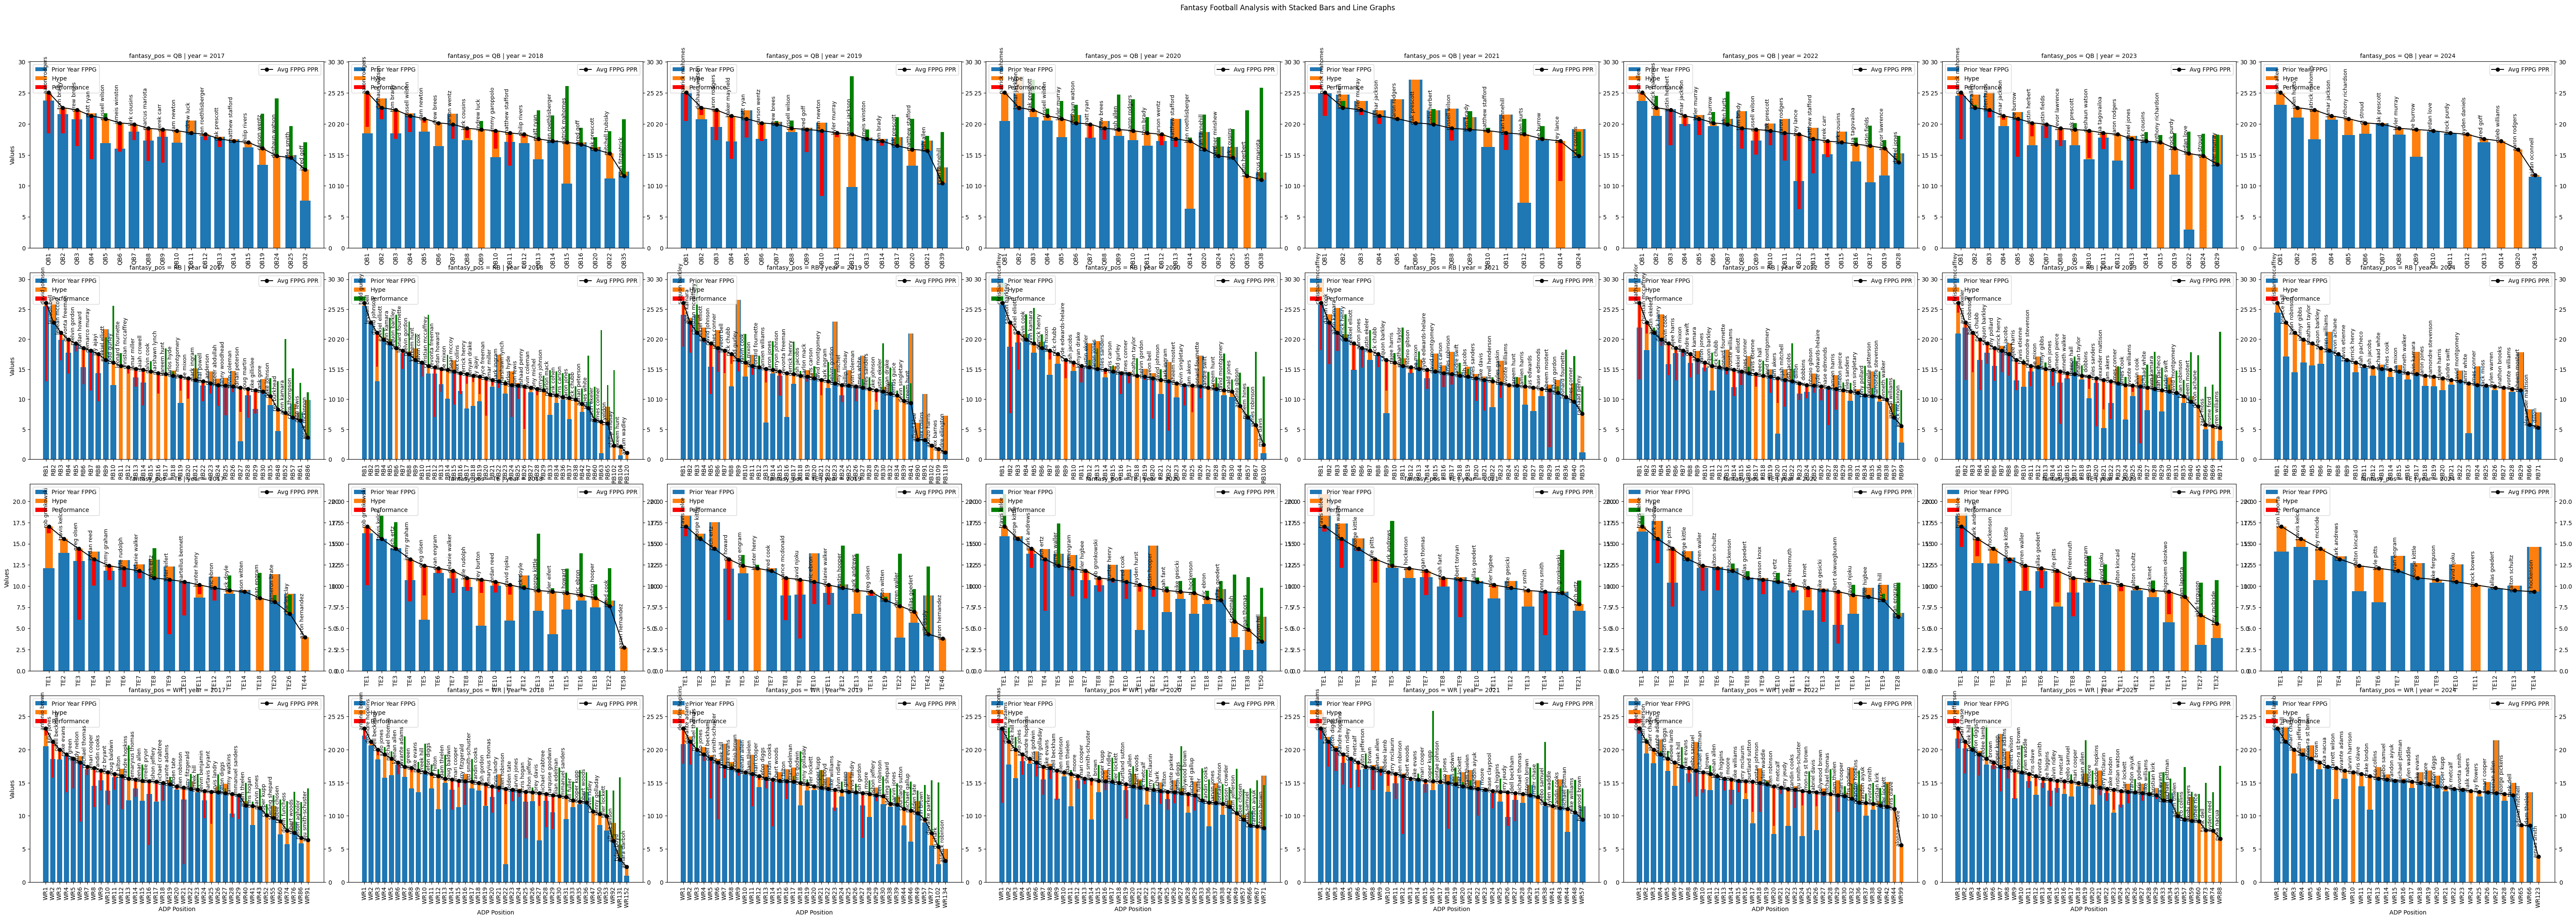

In [720]:
data = pd.DataFrame(df)

# Create the FacetGrid
g = sns.FacetGrid(data, row='fantasy_pos', col='year', height=5, aspect=1.5, sharex=False, sharey=False)

# Loop through each subplot
for (fantasy_pos, year), group in data.groupby(['fantasy_pos', 'year']):
    ax = g.axes[g.row_names.index(fantasy_pos), g.col_names.index(year)]
    
    # Plot stacked bar chart
    prior_year_fppg_bar_width = 0.75
    hype_width = 0.5
    perf_width = 0.25
    prior_year_fppg_bar = ax.bar(group['adp_pos'], group['prior_year_fppg'], width=prior_year_fppg_bar_width, label='Prior Year FPPG')
    hype_bar = ax.bar(group['adp_pos'], group['hype'], bottom=group['prior_year_fppg'], width=hype_width, label='Hype')

    performance_colors = group['perf_color'].map({'TRUE': 'green', 'FALSE': 'red'})
    performance_bar = ax.bar(group['adp_pos'], group['performance'], 
                             bottom=group['prior_year_fppg'] + group['hype'], width=perf_width, label='Performance',color=performance_colors)
    
    # Plot line graph
    ax2 = ax.twinx()
    line = ax2.plot(group['adp_pos'], group['avg_fppg_ppr'], color='black', marker='o', label='Avg FPPG PPR')

    # Add data labels for the line chart
    for i in range(group.shape[0]):
        adp_pos = group['adp_pos'].iloc[i]
        avg_fppg_ppr = group['avg_fppg_ppr'].iloc[i]
        cleaned_player = group['cleaned_player'].iloc[i]
        
        if pd.notna(avg_fppg_ppr):
            ax2.text(adp_pos, avg_fppg_ppr, cleaned_player, fontsize=9, ha='right', rotation=90)
    
    # Combine the limits of the left and right y-axes
    y_min = 0
    y_max = group['avg_fppg_ppr'].max() + 5
    ax.set_ylim(y_min, y_max)
    ax2.set_ylim(y_min, y_max)

    # Add legends
    ax.legend(loc='upper left')
    ax2.legend(loc='upper right')

# Customize the plot
g.set_axis_labels('ADP Position', 'Values')
g.set_xticklabels(rotation=90)
g.fig.suptitle('Fantasy Football Analysis with Stacked Bars and Line Graphs', y=1.05)

plt.show()


In [724]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

In [729]:
%%sql df <<
$graph_q
AND year != '2024'
ORDER BY YEAR ASC, hype

   sqlite:////Users/beoconno/Documents/ff/ff_data/raw_data/adp/src_code/adp.db
 * sqlite:////Users/beoconno/Documents/ff/ff_data/raw_data/nfl/src_code/nfl.db
Done.
Returning data to local variable df


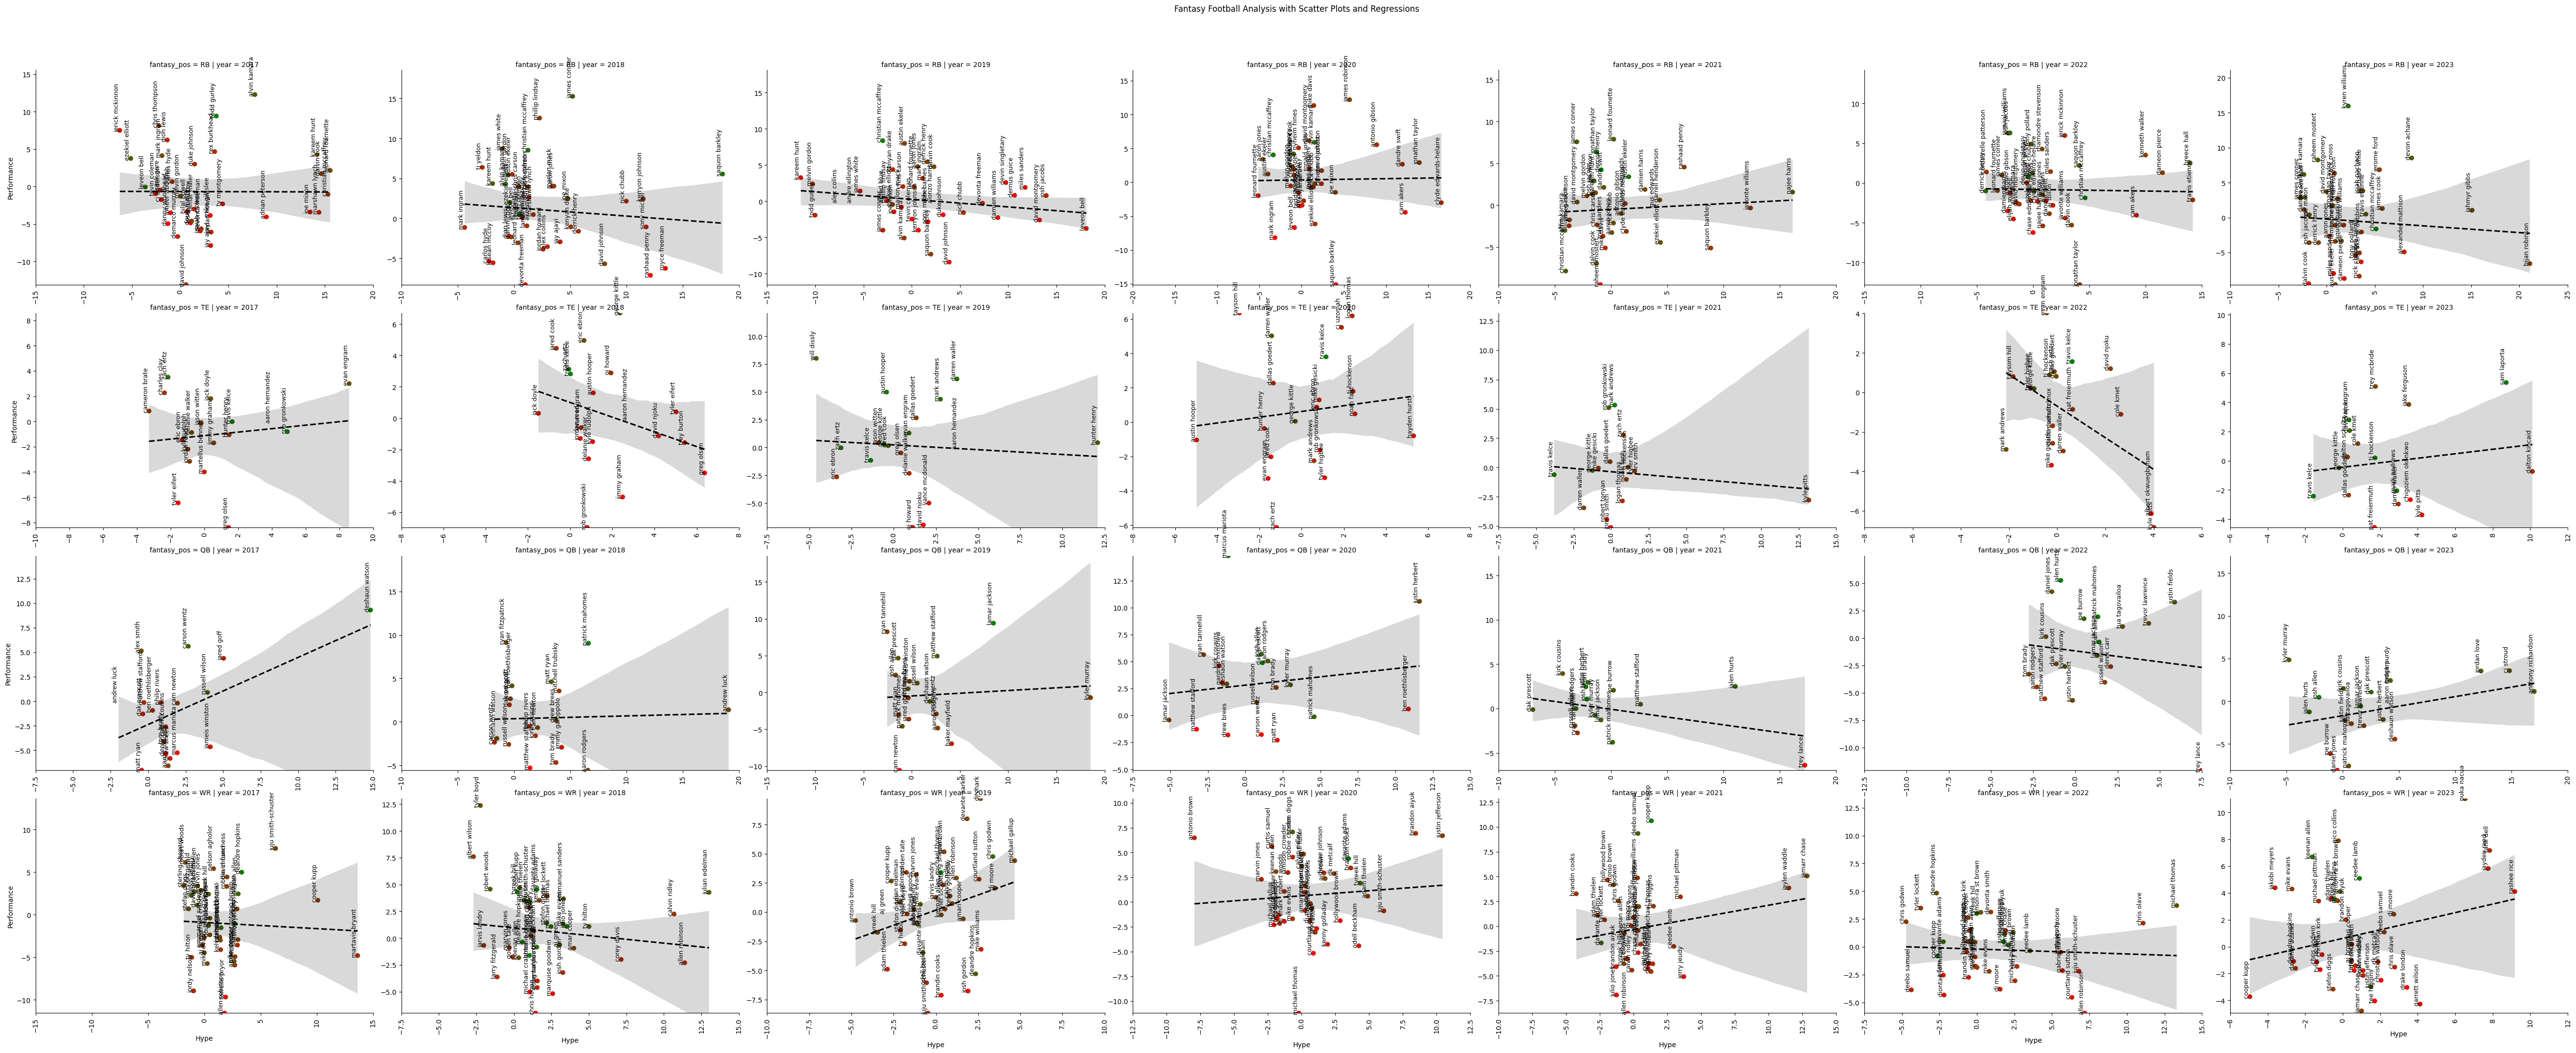

In [730]:
# Example data
data = pd.DataFrame(df)

# Function to map fppg_ppr values to colors
def fppg_ppr_color_map(value, min_value, max_value):
    norm = mcolors.Normalize(vmin=min_value, vmax=max_value)
    cmap = mcolors.LinearSegmentedColormap.from_list("fppg_ppr_cmap", ["red", "green"])
    return cmap(norm(value))

# Create the FacetGrid
g = sns.FacetGrid(data, row='fantasy_pos', col='year', height=5, aspect=1.5, sharex=False, sharey=False)

# Loop through each subplot
for (fantasy_pos, year), group in data.groupby(['fantasy_pos', 'year']):
    ax = g.axes[g.row_names.index(fantasy_pos), g.col_names.index(year)]
    
    # Scatter plot with gradient color based on fppg_ppr
    min_fppg_ppr = group['fppg_ppr'].min()
    max_fppg_ppr = group['fppg_ppr'].max()
    fppg_ppr_colors = [fppg_ppr_color_map(val, min_fppg_ppr, max_fppg_ppr) for val in group['fppg_ppr']]
    scatter = ax.scatter(group['hype'], group['performance'], c=fppg_ppr_colors, label='fppg_ppr')
    
    # Add data labels
    for i in range(group.shape[0]):
        hype_value = group['hype'].iloc[i]
        performance_value = group['performance'].iloc[i]
        cleaned_player = group['cleaned_player'].iloc[i]
        
        if np.isfinite(hype_value) and np.isfinite(performance_value):
            ax.text(hype_value, performance_value, cleaned_player, fontsize=9, ha='right', rotation=90)
    
    # Fit and plot a regression line
    sns.regplot(x='hype', y='performance', data=group, ax=ax, scatter=False, color='black', line_kws={"linestyle":"--"})

    # Set the limits of x-axis and y-axis to be the same
    min_val = min(group['hype'].min()
                  , group['performance'].min())
    max_val = max(group['hype'].max(), group['performance'].max())
    ax.set_xlim(min_val, max_val)
    ax.set_ylim(min_val, max_val)

# Customize the plot
g.set_axis_labels('Hype', 'Performance')
g.fig.suptitle('Fantasy Football Analysis with Scatter Plots and Regressions', y=1.05)

# Turn x-axis labels vertical
g.set_xticklabels(rotation=90)

# Show the plot
plt.show()


In [742]:
graph_perc = """
SELECT
    *,
    CASE
        WHEN fppg_ppr_rank <= 10 THEN 'Top'
        WHEN fppg_ppr_rank <= 20 THEN 'Early'
        WHEN fppg_ppr_rank <= 30 THEN 'Middle'
        WHEN fppg_ppr_rank <= 50 THEN 'Late'
        ELSE 'Dart'
        END AS draft_spot,
    AVG(hype) AS avg_hype,
    ,
FROM nfl_adp_hype
WHERE 1=1
    AND adp_pos IS NOT NULL
    AND COALESCE(fantasy_pos,adp_just_pos) IS NOT NULL
    AND year = '2023'
    AND adp_just_pos = 'RB'
"""

In [744]:
%%sql
$graph_perc
order by year desc, fppg_ppr_rank ASC 
LIMIT 10

   sqlite:////Users/beoconno/Documents/ff/ff_data/raw_data/adp/src_code/adp.db
 * sqlite:////Users/beoconno/Documents/ff/ff_data/raw_data/nfl/src_code/nfl.db
Done.


[('christian mccaffrey', '2023', 'RB', 'RB1', 24.46, 'RB', 1, 20.96, 1, 'RB1', 26.09, 5.13, -1.63, 'Top'),
 ('austin ekeler', '2023', 'RB', 'RB2', 13.24, 'RB', 21, 21.92, 2, 'RB2', 22.83, 0.91, -9.59, 'Top'),
 ('bijan robinson', '2023', 'RB', 'RB3', 14.49, 'RB', 17, 0, 3, 'RB3', 21.08, 21.08, -6.59, 'Top'),
 ('nick chubb', '2023', 'RB', 'RB4', 11.55, 'RB', 31, 16.55, 4, 'RB4', 19.94, 3.39, -8.39, 'Top'),
 ('saquon barkley', '2023', 'RB', 'RB5', 15.94, 'RB', 9, 17.75, 5, 'RB5', 19.29, 1.54, -3.35, 'Top'),
 ('tony pollard', '2023', 'RB', 'RB6', 13.09, 'RB', 23, 15.55, 6, 'RB6', 18.55, 3.0, -5.46, 'Top'),
 ('derrick henry', '2023', 'RB', 'RB7', 14.51, 'RB', 16, 18.93, 7, 'RB7', 18.1, -0.83, -3.59, 'Top'),
 ('josh jacobs', '2023', 'RB', 'RB8', 13.93, 'RB', 18, 19.31, 8, 'RB8', 17.52, -1.79, -3.59, 'Top'),
 ('najee harris', '2023', 'RB', 'RB9', 11.5, 'RB', 32, 13.15, 9, 'RB9', 16.56, 3.41, -5.06, 'Top'),
 ('travis etienne', '2023', 'RB', 'RB10', 16.61, 'RB', 7, 12.06, 10, 'RB10', 16.13, 4.07, 0.48, 'Top')]

In [753]:
hype_rating = """
SELECT
    CASE
        WHEN fppg_ppr_rank <= 10 THEN 'Top'
        WHEN fppg_ppr_rank <= 20 THEN 'Early'
        WHEN fppg_ppr_rank <= 30 THEN 'Middle'
        WHEN fppg_ppr_rank <= 50 THEN 'Late'
        ELSE 'Dart'
        END AS draft_spot,
    MIN(fppg_ppr_rank) AS pos_start,
    MAX(fppg_ppr_rank) AS pos_end,
    ROUND(AVG(hype),2) AS avg_hype,
    MIN(hype) AS least_hype,
    MAX(hype) AS most_hype
FROM nfl_adp_hype
WHERE 1=1
    AND adp_pos IS NOT NULL
    AND COALESCE(fantasy_pos,adp_just_pos) IS NOT NULL
    AND year = '2023'
    AND adp_just_pos = 'RB'
GROUP BY 1
"""

In [754]:
%%sql
$hype_rating
ORDER BY pos_start
LIMIT 10

   sqlite:////Users/beoconno/Documents/ff/ff_data/raw_data/adp/src_code/adp.db
 * sqlite:////Users/beoconno/Documents/ff/ff_data/raw_data/nfl/src_code/nfl.db
Done.


[('Top', 1, 10, 3.99, -1.79, 21.08),
 ('Early', 11, 20, 1.99, -2.25, 15.09),
 ('Middle', 21, 30, 1.73, -2.72, 8.05),
 ('Late', 31, 50, 1.78, -3.17, 10.23),
 ('Dart', 51, 95, 1.77, -7.87, 7.63)]

In [ ]:
"""
AND (
        COALESCE(fantasy_pos,adp_just_pos) IN ('RB', 'WR') AND (fppg_ppr_rank <30 OR actual_pos_finish <30)
        OR COALESCE(fantasy_pos,adp_just_pos) IN ('QB', 'TE') AND (fppg_ppr_rank <15 OR actual_pos_finish <15))
"""

In [773]:
hype_dist = """
SELECT
    COALESCE(fantasy_pos,adp_just_pos) AS pos,
    year,
    CASE
        WHEN fppg_ppr_rank <= 10 THEN 'Top'
        WHEN fppg_ppr_rank <= 20 THEN 'Early'
        WHEN fppg_ppr_rank <= 30 THEN 'Middle'
        WHEN fppg_ppr_rank <= 50 THEN 'Late'
        ELSE 'Dart'
        END AS draft_spot,
    ROUND(hype) AS hype,
    COUNT(1) AS rows
FROM nfl_adp_hype
WHERE 1=1
    AND adp_pos IS NOT NULL
    AND COALESCE(fantasy_pos,adp_just_pos) IS NOT NULL
    AND hype IS NOT NULL
GROUP BY 1, 2, 3,4
"""

In [774]:
%%sql
$hype_dist
LIMIT 10

   sqlite:////Users/beoconno/Documents/ff/ff_data/raw_data/adp/src_code/adp.db
 * sqlite:////Users/beoconno/Documents/ff/ff_data/raw_data/nfl/src_code/nfl.db
Done.


[('QB', '2016', 'Dart', -3.0, 1),
 ('QB', '2016', 'Dart', -1.0, 1),
 ('QB', '2016', 'Dart', 0.0, 11),
 ('QB', '2016', 'Dart', 1.0, 8),
 ('QB', '2016', 'Dart', 2.0, 4),
 ('QB', '2016', 'Dart', 3.0, 2),
 ('QB', '2016', 'Dart', 4.0, 3),
 ('QB', '2016', 'Dart', 5.0, 3),
 ('QB', '2016', 'Early', 16.0, 4),
 ('QB', '2016', 'Early', 17.0, 3)]

   sqlite:////Users/beoconno/Documents/ff/ff_data/raw_data/adp/src_code/adp.db
 * sqlite:////Users/beoconno/Documents/ff/ff_data/raw_data/nfl/src_code/nfl.db
Done.


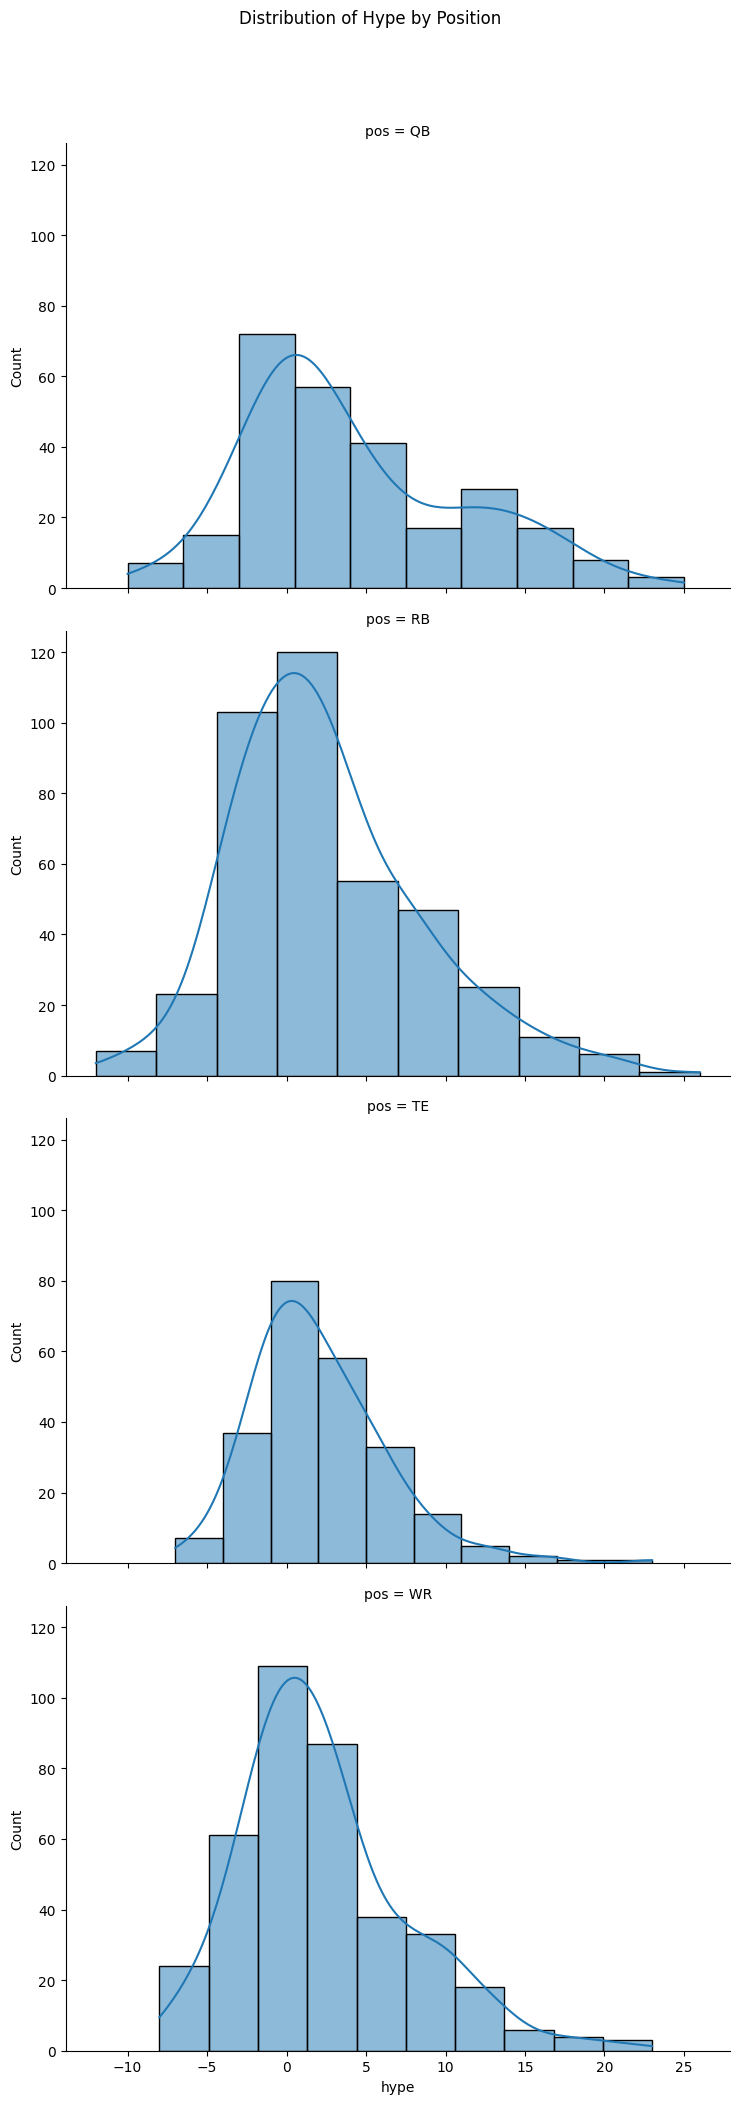

In [783]:
# Example data
df = %sql $hype_dist 
data = pd.DataFrame(df) 

# Example data (replace df with your actual DataFrame)
data = pd.DataFrame(df)

# Create the FacetGrid to plot distributions
g = sns.FacetGrid(data, row='pos', height=5, aspect=1.5, sharex=True, sharey=True)

# Loop through each subplot and plot the distribution
g.map(sns.histplot, 'hype', kde=True, bins=10)

# Customize the layout
g.fig.suptitle('Distribution of Hype by Position', y=1.05)

# Show the plot
plt.show()


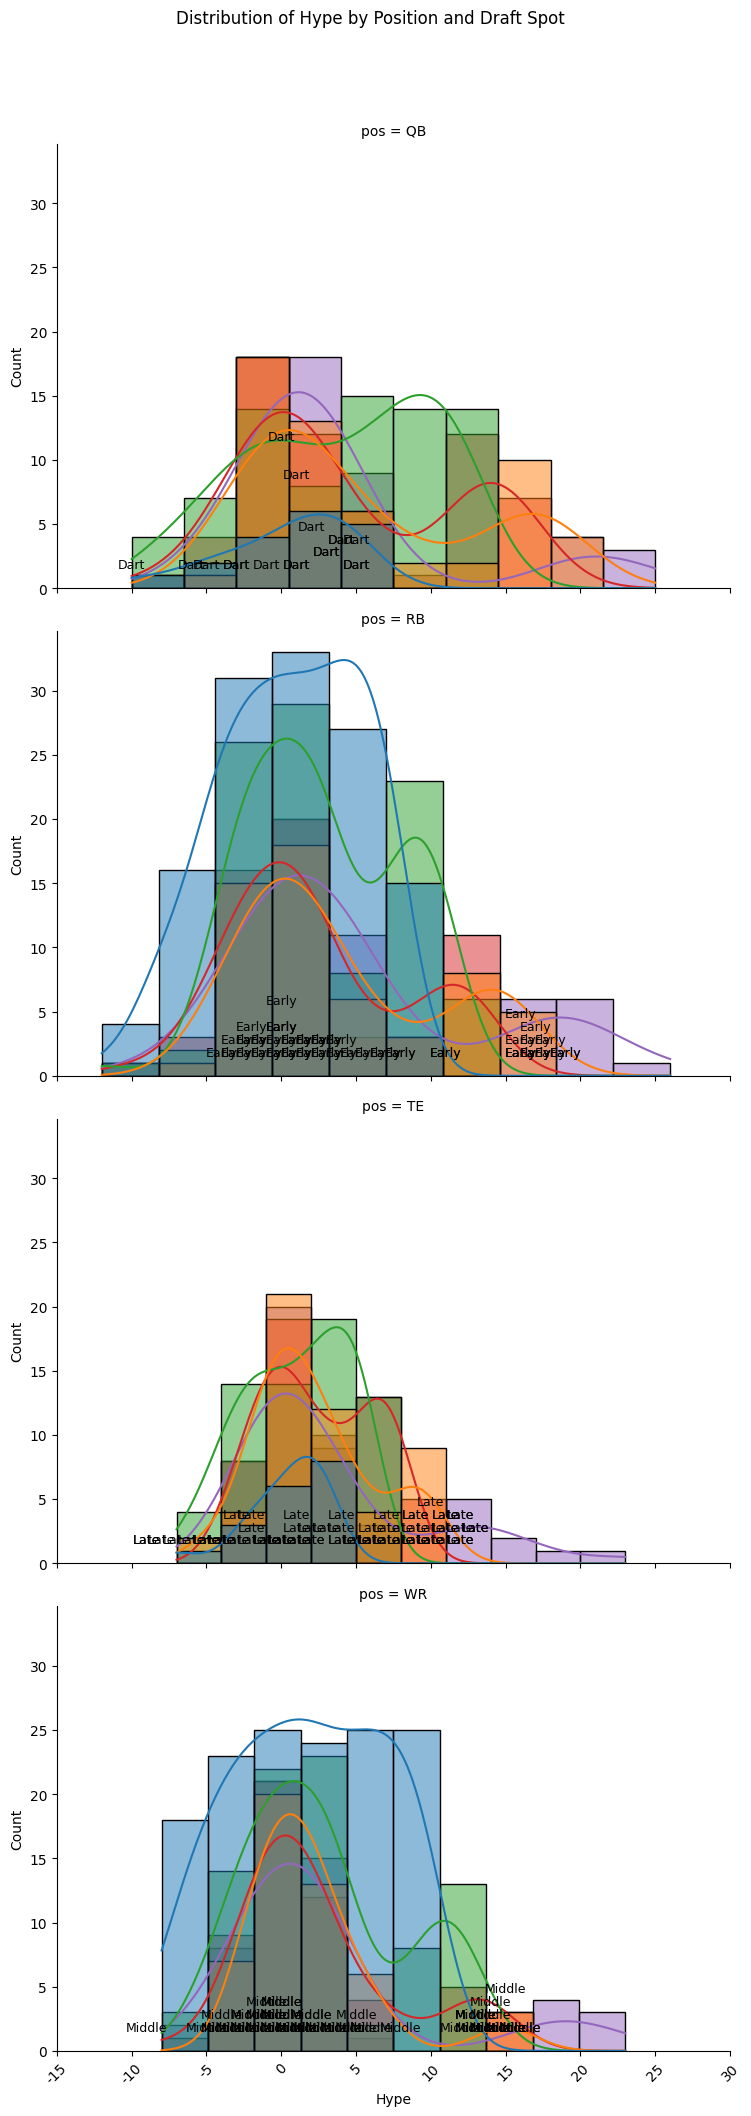

In [796]:
# Example data (replace df with your actual DataFrame)
data = pd.DataFrame(df)

# Create the FacetGrid to plot distributions
g = sns.FacetGrid(data, row='pos', height=5, aspect=1.5, sharex=True, sharey=True)

# Loop through each subplot and plot the distribution
g.map_dataframe(sns.histplot, 'hype', hue='draft_spot', kde=True, bins=10, legend=True)

# Customize the layout
g.fig.suptitle('Distribution of Hype by Position and Draft Spot', y=1.05)

# Annotate each subplot with draft_spot values
for ax, (_, group) in zip(g.axes.flat, data.groupby(['pos', 'draft_spot'])):
    for _, row in group.iterrows():
        ax.annotate(row['draft_spot'], 
                    xy=(row['hype'], row['rows']), 
                    textcoords='offset points', 
                    xytext=(0, 5), 
                    ha='center', fontsize=9)

    # Set x-axis tick labels to ensure they are numerical
    ax.set_xlabel('Hype')
    ax.set_xticks(ax.get_xticks())  # Ensure ticks are set
    ax.set_xticklabels([int(tick) for tick in ax.get_xticks()], rotation=45)  # Convert ticks to int
    
# Show the plot
plt.show()
